# 方策反復法

今回は[森村(2019)](https://www.amazon.co.jp/%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%83%95%E3%82%A7%E3%83%83%E3%82%B7%E3%83%A7%E3%83%8A%E3%83%AB%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E6%A3%AE%E6%9D%91-%E5%93%B2%E9%83%8E/dp/4065155916/ref=sr_1_3?adgrpid=81262430850&gclid=Cj0KCQjwk7ugBhDIARIsAGuvgPYqZnWcQryNTVWKDJT8whZNJ-h73ZqHT6qF2I9bXprKne2GkLHavEIaArExEALw_wcB&hvadid=649107616291&hvdev=c&hvlocphy=1009180&hvnetw=g&hvqmt=e&hvrand=10477133917986279598&hvtargid=kwd-898864963330&hydadcr=15817_13644392&jp-ad-ap=0&keywords=%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92+%E6%A3%AE%E6%9D%91&qid=1678699533&sr=8-3)の本のp.63に書いてある方策反復法のコードを書いていきたいと思います．

方策反復法は動的計画法による回ほうの一種です．

価値反復法では逐次的に価値関数を更新していく流れでしたが，方策反復法では方策を改善していく方法です．

そして方策反復法では現在の方策が最適ではない場合，必ず改善されることが保証されています(p.65)．

---

ここから方策反復法のアルゴリズムについて説明していきます．

$S,A,p,g,\gamma$ をそれぞれ状態の数，行動の数，遷移確率，報酬関数，割引率とします．

1. 決定的方策 $\pi_d : S \rightarrow A$ 任意に初期化．
2. 決定的方策 $\pi_d$ の価値関数 $V^{\pi^d}$ を求める．
$$
V^{\pi^d}(s) = (B_{\pi^d}V^{\pi^d})
$$　
3. 改善方策 $\pi^{d^{'}}$ を求める．
$$
\pi^{d^{'}}(s) := argmax_{a \in A}[g(s,a) + \gamma \sum_{s^{'}\in S} p(s^{'} | s,a)V^{\pi^{d}}(s^{'})]
$$
4. 収束判定は，もし $\pi^{d^{'}}(s)$ = $\pi_d(s)$ なら終了で，それ以外なら $\pi_d := \pi^{d^{'}}$ として繰り返す．

In [39]:
import numpy as np
from typing import NamedTuple

S = 5 #state_size
A = 3  #action_size
S_array = np.arange(S) #state_set
A_array = np.arange(A) #action_set
gamma = 0.99 

rew = np.random.rand(S,A) * 10 #報酬

P = np.random.rand(S*A, S) #遷移確率
P = P / np.sum(P,axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_almost_equal(P.sum(axis=-1),1) #確率1になっているか確認

# MDPの定義

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    rew : np.array
    P : np.array

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)

mdp = MDP(S_array,A_array,gamma,rew,P)
print(mdp.rew.shape)
print(mdp.P.shape)

(5, 3)
(5, 3, 5)


In [49]:
import jax
import jax.numpy as jnp

@jax.jit
def policy_iteration(mdp:MDP, v:jnp.ndarray, pi:jnp.ndarray):
    v = pi * (mdp.rew + mdp.gamma * mdp.P @ v)
    #vの形がS * Aなので
    v = v.max(axis = 1,keepdims=False)
    v_dash = mdp.rew + mdp.gamma * mdp.P @ v
    pi_max = jnp.zeros((S,A))
    #現在のベルマン最適方程式を計算
    pi_max = pi_max.at[np.arange(S),v_dash.argmax(axis=1)].set(1)

    return pi,pi_max,v

Text(0.5, 0, 'iteration')

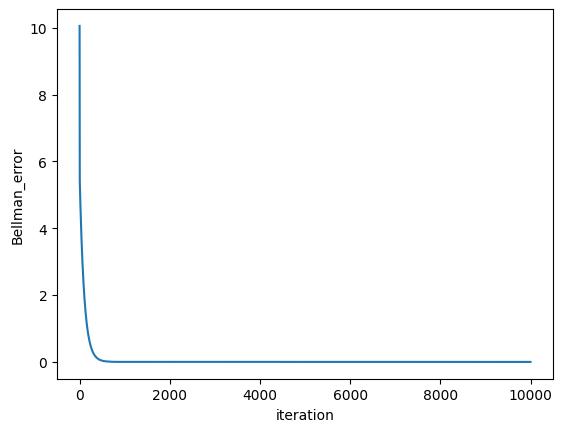

In [55]:
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)

S,A = mdp.S, mdp.A
pi = jnp.zeros((S,A))
#方策は決定的な方策なので，初期化もランダムに決定的な方策にする．
random_index = jax.random.choice(key=key,a = mdp.S-1,shape=(S,))
pi = pi.at[np.arange(S),random_index].set(1)

v_before = jax.random.uniform(key = key,shape = (S,))
errors = []

for i in range(10000):
    pi,pi_max,v_after = policy_iteration(mdp,v_before,pi)
    errors.append(np.abs(v_after - v_before).max())
    v_before = v_after
    if jnp.allclose(pi,pi_max):

        print('終了条件')
        break

    else:
        
        pi_max = pi



plt.plot(errors)
plt.ylabel('Bellman_error')
plt.xlabel('iteration')